# Model proto

This is a rough prototype of our RL solution

In [1]:
import numpy as np
import random
from math import ceil, sqrt
import matplotlib.pyplot as plt

## Environment

This is an implementation of the game environment

In [2]:
def manhattan_distance(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    return abs(x1 - x2) + abs(y1 - y2)

In [3]:
class Action:
    def __init__(self, name):
        self.name = name

    def invoke(self, *args):
        raise RuntimeError('Empty aciton invoked')

class SwordAttack(Action):
    def __init__(self, attack_damage, range=1, name='Sword attack'):
        super().__init__(name)
        self.attack_damage = attack_damage
        self.range = range

    def invoke(self, game, source_unit, target_unit, skip_illegal):
        unit_position = game.get_unit_position(source_unit)
        if not self.check_action_legal(game, unit_position, source_unit, target_unit):
            if not skip_illegal: raise RuntimeError('Too far to attack')
            return None
        
        target_unit.take_damage(self.attack_damage)

    def check_action_legal(self, game, new_position, source_unit, target_unit):
        if source_unit is target_unit: return False
        if target_unit is None: return False
        
        target_pos = game.get_unit_position(target_unit)
        if manhattan_distance(target_pos, new_position) > self.range:
             return False
        return True

In [4]:
class ActionInstance:
    def __init__(self, action = None, **kwargs):
        self.action = action
        self.kwargs = kwargs

    def check_action_legal(self, game, new_position): 
        if self.action is None: return True
        return self.action.check_action_legal(game, new_position, **self.kwargs)
    
    def invoke(self, game, skip_illegal):
        if self.action is None: return None
        return self.action.invoke(game, **self.kwargs, skip_illegal=skip_illegal)

In [5]:
class Unit:
    def __init__(self, name, health, speed):
        self.health = health
        self.name = name
        self.speed = speed
        self.actions = []
    
    def take_damage(self, damage):
        self.health -= damage

    def is_alive(self): return self.health > 0

    def __str__(self): return self.name

class GenericSoldier(Unit):
    def __init__(self, name='Generic soldier', speed=3, health=100, attack_damage=10, name_postfix=""):
        super().__init__(name + name_postfix, health, speed)
        
        self.actions.append(SwordAttack(attack_damage))

In [6]:
def transform_matrix(matrix, func):
    result_matrix = np.empty_like(matrix)

    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            result_matrix[i, j] = func(i, j, matrix[i, j])

    return result_matrix

In [7]:
class DnD():
    def __init__(self, board_dims=(10, 10)):
        # 10x10 finite board for now
        self.board = np.zeros(board_dims, dtype=object)
        self.board.fill(None)
        self.players_to_units = { }
        self.units_to_players = { }
    
    def get_board(self):
        return self.board
    
    def place_unit(self, unit, position, player_index, replace=False):
        """
            Places the given unit at specified position on the board
            If `replace` is False, raises an error on attempt to replace
            an existing unit
        """
        if not replace and self.board[position] is not None:
            raise RuntimeError('This position is already occupied')
        
        self.board[position] = unit
        if player_index not in self.players_to_units: 
            self.players_to_units[player_index] = []
        self.players_to_units[player_index].append(unit)
        self.units_to_players[unit] = player_index
    
    def is_occupied(self, position): return self.board[position] is not None

    def initialize_game(self, check_empty=True):
        self.units = self.board[self.board != None].flatten().tolist()
        if check_empty and len(self.units) == 0:
            raise RuntimeError('The board is empty')
        
        # Assign turn order
        self.turn_order = random.sample(list(range(len(self.units))), len(self.units))
        self.current_turn_index = 0
    
    def get_current_unit(self):
        """
            Returns tuple of (unit, player_id) for the current unit to take turn
            and the player_id that owns the unit
        """
        unit = self.units[self.turn_order[self.current_turn_index]]
        return unit, self.units_to_players[unit]
    
    def get_unit_position(self, unit):
        return np.where(self.board == unit)
    
    def get_distance(self, unit1, unit2):
        pos1 = self.get_unit_position(unit1)
        pos2 = self.get_unit_position(unit2)
        return manhattan_distance(pos1, pos2)

    def check_move_legal(self, new_position, verbose=False):
        unit, player_id = self.get_current_unit()
        unit_position = self.get_unit_position(unit)
        target_cell = self.board[new_position]

        if target_cell is not None and target_cell is not unit:
            if verbose: print('Cell occupied')
            return False

        if manhattan_distance(unit_position, new_position) > unit.speed:
            if verbose: print('Too far')
            return False
        
        return True
    
    def check_action_legal(self, new_position, action, verbose=False):
        if action is None: return True

        if not action.check_action_legal(self, new_position):
            if verbose: print('Action illegal')
            return False
        
        unit, player_id = self.get_current_unit()
        if action.action is not None and action.action not in unit.actions:
            if verbose: print('Action invalid')
            return False
        
        return True
    
    def remove_unit(self, unit):
        unit_pos = self.get_unit_position(unit)
        player_id = self.units_to_players.pop(unit)
        unit_index = self.units.index(unit)
        self.units.remove(unit)
        self.players_to_units[player_id].remove(unit)
        self.board[unit_pos] = None
        unit_turn_value = self.turn_order[unit_index]
        self.turn_order.remove(unit_turn_value)

        for i in range(len(self.turn_order)):
            if self.turn_order[i] < unit_turn_value: continue
            self.turn_order[i] -= 1

        if self.current_turn_index >= unit_turn_value:
            self.current_turn_index -= 1

    def update_board(self):
        to_remove = []

        for unit in self.units:
            if unit.is_alive(): continue
            to_remove.append((unit, self.units_to_players[unit]))

        for unit, player_id in to_remove: self.remove_unit(unit)

        return { 'units_removed': to_remove }

    # for the current unit to move in
    def get_legal_positions(self):
        current_unit, player_id = self.get_current_unit()
        pos = self.get_unit_position(current_unit)

        def is_legal(x, y, unit):
            if unit is not None and unit is not current_unit: return False
            return manhattan_distance(pos, (x, y)) <= current_unit.speed
        
        return transform_matrix(self.board, is_legal).astype(bool)

    def take_turn(self, new_position, action, skip_illegal=False):
        move_legal = self.check_move_legal(new_position)
        unit, player_id = self.get_current_unit()

        if not move_legal:
            if not skip_illegal: raise RuntimeError('Illegal move')
        else:
            unit_pos = self.get_unit_position(unit)
            self.board[unit_pos] = None
            self.board[new_position] = unit

        if not self.check_action_legal(new_position, action):
            if not skip_illegal: raise RuntimeError('Illegal action')

            self.current_turn_index = (self.current_turn_index + 1) % len(self.units)
            return 0, False

        if action is not None: action.invoke(self, skip_illegal=skip_illegal)
        update = self.update_board()
        self.current_turn_index = (self.current_turn_index + 1) % len(self.units)
        
        ### Stuff for agent

        reward = 0
        game_over = False
        # reward for removing enemy units, 1 for each unit
        reward += len([x for x in update['units_removed'] if x[1] != player_id])
        # reward for defeating players
        reward += 5 * len([x for x in update['units_removed'] if len(self.players_to_units[x[1]]) == 0 and x[1] != player_id])
        # reward for winning
        if len(self.players_to_units[player_id]) == len(self.units):
            game_over = True
            reward += 10
        # penalty for losing (on your own turn ??)
        if len(self.players_to_units[player_id]) == 0:
            game_over = True
            reward = -10
        
        return reward, game_over

    def observe_board(self):
        current_unit, player_id = self.get_current_unit()
        ally_units = transform_matrix(self.board, lambda x, y, z: (z is not None) and (self.units_to_players[z] == player_id)).astype(bool)
        enemy_units = (self.board != None) ^ ally_units
        unit_to_move = np.zeros(ally_units.shape, dtype=bool)
        unit_to_move[self.get_unit_position(current_unit)] = True
        speeds = transform_matrix(self.board, lambda x,y,z: 0 if z is None else z.speed)
        attack_ranges = transform_matrix(self.board, lambda x,y,z: 0 if z is None else z.actions[0].range)
        attack_damages = transform_matrix(self.board, lambda x,y,z: 0 if z is None else z.actions[0].attack_damage)

        return np.array([
            ally_units,
            enemy_units,
            unit_to_move,
            speeds,
            attack_ranges,
            attack_damages
        ], dtype=np.float32)

### Utils

In [8]:
def print_game(game, unit_to_color):
    COLORS = {
        "Red": "\033[91m",
        "Green": "\033[92m",
        "Blue": "\033[94m",
        "Purple": "\033[95m",
        "Orange": "\033[93m",
        "Cyan": "\033[96m",
        "Magenta": "\033[95m",
        "Reset": "\033[0m",
    }

    num_rows, num_cols = game.board.shape
    number_padding = 2

    print(f'Units alive: {len(game.units)}')
    print(f'Players: {len(game.players_to_units)}:')
    for player_id in game.players_to_units:
        units = game.players_to_units[player_id]
        print(f'\tPlayer #{player_id} ({len(units)} units): ', end='')
        for unit in units:
            color = unit_to_color[unit]
            print(f'`{COLORS[color]}{unit.name} ({unit.health} HP){COLORS["Reset"]}`', end=', ')
        print("\b\b  ")
    print(f'\t')

    print(" " * (number_padding + 1), end="")  # Offset for y-axis numbering
    for j in range(num_cols):
        print(f"{j:>{number_padding}}", end="")

    print()

    # Print the matrix with numbering on both axes, "empty," and compact grid
    for i in range(num_rows):
        # Print y-axis numbering on the left without colons
        print(f"{i:>{number_padding}} ", end="")

        for j in range(num_cols):
            unit = game.board[i, j]
            if unit is None:
                formatted_value = "  "  # Represents "empty" with two space characters
            else:
                color = unit_to_color[unit]
                formatted_value = f"{COLORS[color]}██{COLORS['Reset']}"  # Colorize # characters
            print(formatted_value, end="")

        print(f"{i:>{number_padding}} ")

    # Print x-axis numbering at the bottom
    print(" " * (number_padding + 1), end="")  # Offset for y-axis numbering
    for j in range(num_cols):
        print(f"{j:>{number_padding}}", end="")

    print('\n')

    unit, player_id = game.get_current_unit()
    color = unit_to_color[unit]
    print(f'Next move is by player #{player_id}: `{COLORS[color]}{unit.name}{COLORS["Reset"]}`')


## Neural network

Probably the most basic thing I could come up with

In [9]:
import torch
from torch import nn

In [10]:
class DnDEvalModel(nn.Module):
    def __init__(self, in_layers, out_layers):
        super(DnDEvalModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_layers, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 64, 5, padding=2),
            nn.ReLU(),
            nn.Conv2d(64, 16, 5, padding=2),
            nn.ReLU(),
            nn.Conv2d(16, out_layers, 3, padding=1),
        )

    def forward(self, x):
        return self.layers(x)

## Agent

In [11]:
def to_tuple(coords):
    return tuple(np.array(coords).flatten())

In [12]:
import os

class DnDAgent():
    def __init__(self, game, board_shape, in_channels=6, out_actions=1, lr=0.001, epsilon=0.99, min_epsilon=0.01, epsilon_delta=1e-5, gamma=0.9, memory_capacity=100000, batch_size=128):
        # out_layers:
        # new_unit_coords, target_unit
        self.game = game
        self.in_channels = in_channels
        self.out_channels = out_actions
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = DnDEvalModel(self.in_channels, self.out_channels).train().to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = lr)
        self.loss_fn = nn.MSELoss()
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_delta = epsilon_delta
        self.gamma = gamma
        self.memory_capacity = memory_capacity
        self.batch_size = batch_size
        self.memory_position = 0
        state_shape = (memory_capacity, self.in_channels, *board_shape)
        actions_shape = (memory_capacity, self.out_channels, 2) # 2 - [x, y] coordinates
        self.state_memory = np.zeros(state_shape, dtype=np.float32)
        self.new_state_memory = np.zeros(state_shape, dtype=np.float32)
        self.actions_memory = np.zeros(actions_shape, dtype=np.float32)
        self.reward_memory = np.zeros(memory_capacity, dtype=np.float32)
        self.game_over_memory = np.zeros(memory_capacity, dtype=np.bool_)
        self.memory_bound = 0
    
    def predict(self, state):
        return self.model(torch.tensor(state).to(self.device).unsqueeze(0)).detach().cpu().numpy()[0]

    def choose_action(self, state = None):
        if state is None: state = self.game.observe_board()
        current_unit, player_id = self.game.get_current_unit()

        if random.random() < self.epsilon:
            legal_moves = self.game.get_legal_positions()
            new_pos = random.choice(list(zip(*np.where(legal_moves))))
            target_pos = random.choice(list(zip(*np.where(state[1]))))
            target_unit = self.game.board[target_pos]

            action = ActionInstance(current_unit.actions[0], source_unit=current_unit, target_unit=target_unit)

            return new_pos, action, (new_pos, target_pos)

        output = self.predict(state)
        new_pos = to_tuple(np.argwhere(output[0] == np.max(output[0]))[0])
        target_pos = to_tuple(np.argwhere(output[1] == np.max(output[1]))[0])
        target_unit = self.game.board[target_pos]
        action = ActionInstance(current_unit.actions[0], source_unit=current_unit, target_unit=target_unit)
        return new_pos, action, (new_pos, target_pos)
        
    def save_model(self, path='../checkpoints/', name='unnamed'):
        torch.save(self.model.state_dict(), os.path.join(path, f'{name}.pt'))
        torch.save(self.optimizer.state_dict(), os.path.join(path, f'{name}-optim.pt'))

    def load_model(self, path='../checkpoints/', name='unnamed'):
        self.model.load_state_dict(torch.load(os.path.join(path, f'{name}.pt')))
        self.optimizer.load_state_dict(torch.load(os.path.join(path, f'{name}-optim.pt')))

    def memorize(self, state, actions, reward, new_state, game_over):
        self.state_memory[self.memory_position] = state
        self.reward_memory[self.memory_position] = reward
        self.new_state_memory[self.memory_position] = new_state
        self.game_over_memory[self.memory_position] = game_over
        self.actions_memory[self.memory_position] = actions

        self.memory_position = (self.memory_position + 1) % self.memory_capacity
        self.memory_bound = max(self.memory_bound, self.memory_position) 

    def learn(self):
        if self.memory_bound < self.batch_size: return

        self.optimizer.zero_grad()

        batch_indices = np.random.choice(self.memory_bound, self.batch_size, replace=False)

        states = torch.tensor(self.state_memory[batch_indices]).to(self.device)
        new_states = torch.tensor(self.new_state_memory[batch_indices]).to(self.device)
        rewards = torch.tensor(self.reward_memory[batch_indices]).to(self.device)
        actions = self.actions_memory[batch_indices] # (128, 2, 2)
        game_overs = self.game_over_memory[batch_indices]

        q_evals = self.model(states) # [B, 2, H, W]
        q_nexts = self.model(new_states).view(self.batch_size, self.out_channels, -1) # [B, 2, H*W]

        batch_index = np.arange(self.batch_size, dtype=np.int32)

        q_target = torch.clone(q_evals)
        for i in range(self.out_channels):
            action_map = actions[:, i]
            q_target[batch_index, i, action_map[:, 0], action_map[:, 1]] = rewards + self.gamma * torch.max(q_nexts[:,i], dim=1)[0]

        loss = self.loss_fn(q_evals, q_target)
        loss.backward()
        self.optimizer.step()

        self.epsilon = max(self.epsilon - self.epsilon_delta, self.min_epsilon)

## Sample agent game

In [13]:
def take_turn(game, new_coords, action, unit_to_color, agent=False, prnt_game=True, print_move=True):
    COLORS = {
        "Red": "\033[91m",
        "Green": "\033[92m",
        "Blue": "\033[94m",
        "Purple": "\033[95m",
        "Orange": "\033[93m",
        "Cyan": "\033[96m",
        "Magenta": "\033[95m",
        "Reset": "\033[0m",
    }

    unit, player_id = game.get_current_unit()
    color = unit_to_color[unit]
    if print_move: print(f'Turn made by player #{player_id}: `{COLORS[color]}{unit.name}{COLORS["Reset"]}`:')
    old_coords = to_tuple(game.get_unit_position(unit))
    new_coords = to_tuple(new_coords)
    if print_move: print(f'\tUnit {"moves" if old_coords != new_coords else "does not move"}: {old_coords} -> {new_coords};')
    if print_move:
        if action is None:
            print('\tAnd does not take any action!')
        else:
            print(f'\tAnd takes aciton `{action.action.name}` with attributes: {({key: str(value) for key, value in action.kwargs.items()})}')

    reward, game_over = game.take_turn(new_coords, action, skip_illegal=agent)

    if prnt_game: 
        print()
        print_game(game, unit_to_color)

    return reward, game_over

In [14]:
agent = DnDAgent(None, lr=0.001, board_shape=(5, 5), epsilon_delta=1e-4, in_channels=6, out_actions=2, batch_size=128)
iters = []

In [15]:
def get_random_coords(h, w):
    return random.randrange(0, h), random.randrange(0, w)

In [16]:
def place_unit_randomly(game, board_size, unit, player_id):
    while True:
        try:
            game.place_unit(unit, get_random_coords(*board_size), player_id)
        except:
            continue
        return

def create_same_game(board_size = (5, 5)):
    game = DnD(board_size)
    ally = GenericSoldier("Ally soldier", attack_damage=100)
    ally.actions[0].range = 2
    ally2 = GenericSoldier("Ally dmg soldier", 1, 50, 25)
    enemy = GenericSoldier("Enemy soldier", attack_damage=100)
    enemy.actions[0].range = 2
    enemy2 = GenericSoldier("Enemy tank soldier", 1, 250, 4)
    
    place_unit_randomly(game, board_size, ally, 0)
    place_unit_randomly(game, board_size, enemy, 1)
    # place_unit_randomly(game, board_size, ally2, 0)
    # place_unit_randomly(game, board_size, enemy2, 1)
   
    game.initialize_game()

    color_map = {
        ally: "Green",
        enemy: "Red",
        ally2: "Blue",
        enemy2: "Purple"
    }

    # print_game(game, color_map)

    return game, color_map

In [17]:
import time
from IPython.display import clear_output


def play_game(game, color_map, print_games=True, delay=0.5):
    game_over = False
    iter_ = 0

    if print_games:
        print_game(game, color_map)
        time.sleep(delay)
    
    last_state, last_reward, last_action = None, None, None
    while not game_over:
        iter_ += 1
        print_iter = print_games #iter_ % 10 == 0
#
        if print_iter:
            clear_output(wait=True)
            print(f'Iteration: {iter_}')
    
        state = game.observe_board()
        new_coords, action, action_tuple = agent.choose_action(state)
    
        reward, game_over = take_turn(game, new_coords, action, color_map, True, print_iter, print_iter)
        new_state = game.observe_board()

        ## THIS IS WRONG, FIX REWARD
        if last_state is not None:
            total_reward = last_reward - reward
            agent.memorize(last_state, last_action, total_reward, new_state, game_over)
            
        if game_over:
            agent.memorize(state, action_tuple, reward, new_state, game_over)
        
        agent.learn()
        last_state = state
        last_action = action_tuple
        last_reward = reward
        
        if print_games: time.sleep(delay)
    
    if print_games: print(f'\nGame over in {iter_} iterations. Current epsilon = {agent.epsilon}')

    return iter_

In [18]:
games = 5000
from tqdm.auto import tqdm

with tqdm(range(games), desc='Game') as pbar:
    for i in pbar:
        game, color_map = create_same_game()
        agent.game = game
        its = play_game(game, color_map, False)
        iters.append(its)

Game:   0%|          | 0/5000 [00:00<?, ?it/s]

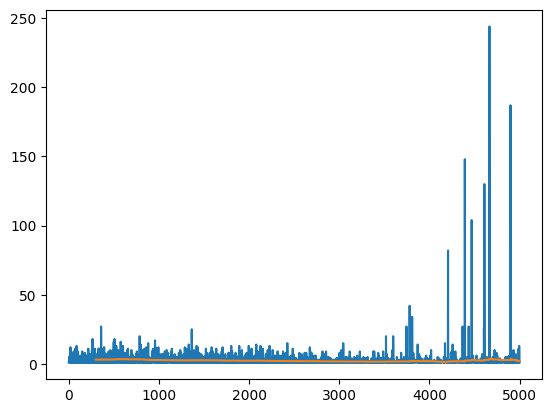

In [19]:
start_from = 0

itersl = iters[start_from:]
n = 300
plt.plot(itersl)
smoth = np.convolve(itersl, np.ones(n) / n, mode='valid')
plt.plot(range(n, len(smoth) + n), smoth)
plt.show()

In [20]:
agent.epsilon

0.01

In [21]:
game, color_map = create_same_game()
agent.game = game
play_game(game, color_map, delay=1)

Iteration: 2
Turn made by player #1: `Enemy soldier`:
	Unit moves: (0, 4) -> (0, 3);
	And takes aciton `Sword attack` with attributes: {'source_unit': 'Enemy soldier', 'target_unit': 'Ally soldier'}

Units alive: 1
Players: 2:
	Player #0 (0 units)  
	Player #1 (1 units): `Enemy soldier (100 HP)`  
	
    0 1 2 3 4
 0       ██   0 
 1            1 
 2            2 
 3            3 
 4            4 
    0 1 2 3 4

Next move is by player #1: `Enemy soldier`

Game over in 2 iterations. Current epsilon = 0.01


2

# Visualization

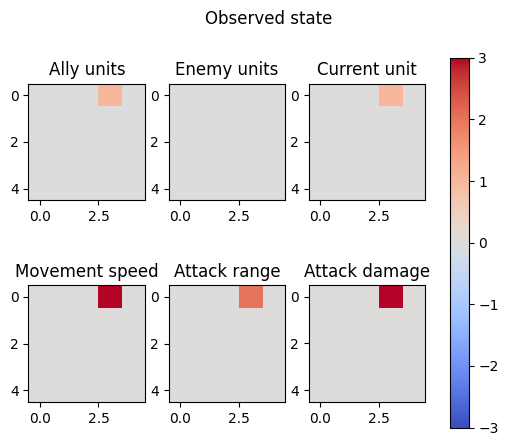

In [22]:
def plot_featuremaps(data, name="", fm_names=None, vmin=None, vmax=None, shape=None, separate_cbars=False, show=True):
    if shape is None:
        width = int(ceil(sqrt(data.shape[0])))
        height = int(ceil(data.shape[0] / width))
        shape = (height, width)
    
    if vmin is None and not separate_cbars: vmin = np.min(data)
    if vmax is None and not separate_cbars: vmax = np.max(data)

    fig, ax_m = plt.subplots(*shape, dpi=100)
    fig.suptitle(name)
    axs = np.asarray(ax_m).ravel()
    imgs = []
    for i, (fm, ax) in enumerate(zip(data, axs)):
        imgs.append(ax.imshow(fm, cmap='coolwarm', vmin=vmin, vmax=vmax))
        if fm_names is not None:
            ax.set_title(fm_names[i])
        
        if separate_cbars:
            fig.colorbar(imgs[i], ax=ax)

    if not separate_cbars:
        fig.colorbar(imgs[0], ax=axs)
    
    if show: 
        if separate_cbars: plt.tight_layout()
        plt.show()


state = game.observe_board()
plot_featuremaps(
    state, 
    name='Observed state', 
    fm_names=['Ally units', 'Enemy units', 'Current unit', 'Movement speed', 'Attack range', 'Attack damage'],
    vmin = -3,
    vmax = 3,
)

In [23]:
game, color_map = create_same_game()
agent.game = game
print_game(game, color_map)

Units alive: 2
Players: 2:
	Player #0 (1 units): `Ally soldier (100 HP)`  
	Player #1 (1 units): `Enemy soldier (100 HP)`  
	
    0 1 2 3 4
 0            0 
 1 ██         1 
 2            2 
 3            3 
 4         ██ 4 
    0 1 2 3 4

Next move is by player #0: `Ally soldier`


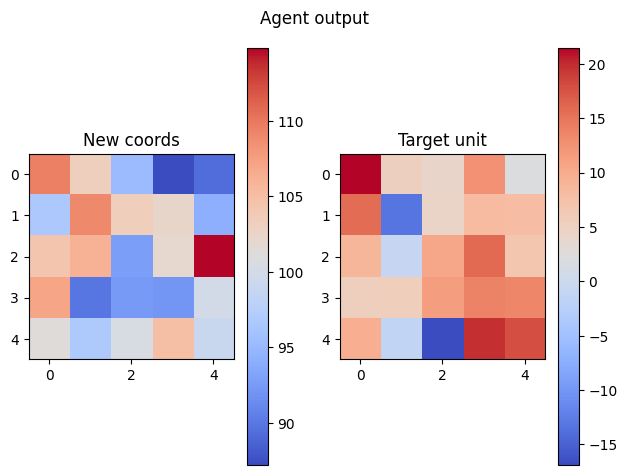

((0, 3), (0, 3))


In [28]:
output = agent.model(torch.tensor(game.observe_board()).to(agent.device).unsqueeze(0)).detach().cpu().numpy()[0]

plot_featuremaps(
    output, 
    name='Agent output', 
    fm_names=['New coords', 'Target unit'],
    separate_cbars=True,
)

print(agent.choose_action(state)[2])